# Imports

In [27]:
import sys

# Detect Colab environment
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import drive, auth
    from googleapiclient.discovery import build
    from googleapiclient.http import MediaIoBaseDownload
    !pip install pwlf

    import pwlf

    auth.authenticate_user()
    drive.mount("/content/drive")
else:
    import pwlf
    from oauth2client.service_account import ServiceAccountCredentials

    print("Running outside Colab (VS Code/local)")

try:
    import gspread
except ModuleNotFoundError:
    if IN_COLAB and "google.colab" in str(get_ipython()):
        %pip install gspread
    import gspread

from gspread_dataframe import set_with_dataframe

Running outside Colab (VS Code/local)


In [28]:

import os

import time

import math
import scipy.stats as stats
import pandas as pd
import numpy as np

from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Poisson
from statsmodels.genmod.cov_struct import Autoregressive

from scipy.stats import chi2
from sklearn.linear_model import Ridge
import statsmodels.api as sm
import copy


from openpyxl import load_workbook
from openpyxl.styles import Alignment

from scipy.stats import linregress, ttest_ind, ttest_rel, ttest_1samp
import matplotlib.pyplot as plt
import re
from openpyxl.drawing.image import Image
from matplotlib.font_manager import FontProperties
from io import BytesIO
import statsmodels.formula.api as smf
import statsmodels.api as sm

import numpy as np
import plotly.graph_objects as go


from datetime import datetime, timedelta

from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from statsmodels.genmod.families import Gamma
from dateutil.relativedelta import relativedelta

from sklearn import set_config
set_config(display="diagram")

import logging
from typing import Dict, Any

import io

# ARGS

In [29]:
MODEL_DEF = 'GLM'
RAW_ATD_VAR = 'mental_health_visits'
RAW_TOTAL_ATD_VAR = 'total_atd'
IR_VAR = 'IR'
IR_SCALE = 1000
DATE_NAME = "date"
GROUP_COL_NAME = "regiao"
LOCAL_OUTPUT_PATH = "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\output\\output.xlsx"

INDEPENDENT_VAR = "periodo"  ### Y
DEPENDENT_VAR = RAW_ATD_VAR if (MODEL_DEF == "GEE" or MODEL_DEF == "GLM") else IR_VAR

# Load Data

In [30]:
dados_brutos = None
output_wksheet = None

input_path = "https://docs.google.com/spreadsheets/d/1m3eEaxWT4Unb8jBZWKjiLivavfA0x3PT1F1Rz1eXwVE/edit?gid=0"
output_path = "https://docs.google.com/spreadsheets/d/1RzC3DfKNUwYA-qfUN0i53hUwRkWGMBOCoYQqdqG4MQY/edit?gid=0"

local_input_path = (
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input.csv" ### poa
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_backup_com_aps_total_RS.xlsx" ### rs
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_backup_com_aps_total.xlsx"
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_backup_com_aps_total_RS_percentual.xlsx"
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_IR_1000_poa.xlsx"
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_IR_1000_brasil.xlsx"
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\regions_IR_1000.xlsx"
    "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\raw_regions_joined.xlsx"
)

output_wksheet = None

if IN_COLAB:
    import gspread
    from google.auth import default

    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    workbook = gc.open_by_url(input_path)
    worksheets = workbook.worksheets()
    output_wksheet = gc.open_by_url(output_path)
    dados_brutos = worksheets[0].get_all_values()
else:
    try:
        dados_brutos = pd.read_csv(local_input_path, header=None).values.tolist()
    except:
        dados_brutos = pd.read_excel(local_input_path, header=None).values.tolist()

In [31]:
def BuildDataDF(data):
    string_dates = data[0][1:]  # Store original string dates

    # Converter as strings de datas em objetos datetime
    #date_list = [datetime.strptime(date, "%d/%m/%Y") for date in string_dates]
    date_list = [
    date if isinstance(date, datetime) else datetime.strptime(date, "%d/%m/%Y")
    for date in string_dates
    ]

    # Extrair os nomes das variáveis
    variavel = [row[0] for row in data[1:]]

    # Extrair os dados (sem agrupamento)
    dados = [row[1:] for row in data[1:]]
    dados = np.array(dados, dtype=float)  # Converter para tipo object para evitar warning

    # Criar o DataFrame with DatetimeIndex
    df = pd.DataFrame(data=dados, index=variavel, columns=pd.DatetimeIndex(date_list))

    return df

In [32]:
class MeltTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        var_name=GROUP_COL_NAME,
        value_name=RAW_ATD_VAR,
        date_name=DATE_NAME,
        y_name=INDEPENDENT_VAR,
        perform_IR=False,
        total_suffix="_total",
        total_column_name=RAW_TOTAL_ATD_VAR,
    ):
        self.var_name = var_name
        self.value_name = value_name
        self.date_name = date_name
        self.y_name = y_name
        self.perform_IR = perform_IR
        self.total_suffix = total_suffix
        self.total_column_name = total_column_name

    def fit(self, X, y=None):
        # Nothing to learn, so just return self
        return self

    def transform(self, X):
        # Separate rows with the `_total` suffix
        if self.perform_IR:
            reserved_rows = X[X.index.str.endswith(self.total_suffix)]
            remaining_rows = X[~X.index.str.endswith(self.total_suffix)]

            # Transpose and reset index for the remaining rows
            df_long = remaining_rows.T.reset_index()

            # Rename index to date_name
            df_long = df_long.rename(columns={"index": self.date_name})

            # Melt the DataFrame
            df_long = pd.melt(
                df_long,
                id_vars=[self.date_name],
                var_name=self.var_name,
                value_name=self.value_name,
            )

            # Sort by category and date
            df_final = df_long.sort_values([self.var_name, self.date_name]).reset_index(
                drop=True
            )

            # Add the `total_atd` column
            reserved_rows = reserved_rows.T.reset_index().rename(columns={"index": self.date_name})
            reserved_rows_long = pd.melt(
                reserved_rows,
                id_vars=[self.date_name],
                var_name=self.var_name,
                value_name=self.total_column_name,
            )

            # Remove the `_total` suffix from the var_name in reserved_rows_long
            reserved_rows_long[self.var_name] = reserved_rows_long[self.var_name].str.replace(
                self.total_suffix, "", regex=False
            )

            # Merge the `total_atd` column into the final DataFrame
            df_final = df_final.merge(
                reserved_rows_long,
                on=[self.date_name, self.var_name],
                how="left",
            )
        else:
                        # Transpose and reset index for the remaining rows
            df_long = X.T.reset_index()

            # Rename index to date_name
            df_long = df_long.rename(columns={"index": self.date_name})

            # Melt the DataFrame
            df_long = pd.melt(
                df_long,
                id_vars=[self.date_name],
                var_name=self.var_name,
                value_name=self.value_name,
            )

            # Sort by category and date
            df_final = df_long.sort_values([self.var_name, self.date_name]).reset_index(
                drop=True
            )


        return df_final

# Build DF

In [33]:
pipe = Pipeline(
    [

        ("melt", MeltTransformer(perform_IR=True)),
    ]
)

RawDataDF = BuildDataDF(dados_brutos)
RegressionDF = pipe.fit_transform(RawDataDF)
RegressionDF = RegressionDF[RegressionDF['date'] <= '2023-12-01']

print(RegressionDF)

          date  regiao  mental_health_visits   total_atd
0   2016-01-01  Brasil              111066.0   8232396.0
1   2016-02-01  Brasil              122505.0  10104083.0
2   2016-03-01  Brasil              149843.0  13130885.0
3   2016-04-01  Brasil              129201.0  11242471.0
4   2016-05-01  Brasil              137556.0  11755506.0
..         ...     ...                   ...         ...
631 2023-08-01     sul              232746.0   7448532.0
632 2023-09-01     sul              198259.0   6122598.0
633 2023-10-01     sul              220146.0   7046997.0
634 2023-11-01     sul              205598.0   6625712.0
635 2023-12-01     sul              173491.0   5590252.0

[576 rows x 4 columns]


# gpt


--- Região: Brasil ---
                  Generalized Linear Model Regression Results                   
Dep. Variable:     mental_health_visits   No. Observations:                   95
Model:                              GLM   Df Residuals:                       89
Model Family:          NegativeBinomial   Df Model:                            5
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -1318.3
Date:                  qui, 01 mai 2025   Deviance:                      0.77984
Time:                          14:43:12   Pearson chi2:                    0.794
No. Iterations:                       6   Pseudo R-squ. (CS):            0.06838
Covariance Type:                    HAC                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

c:\Users\Lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


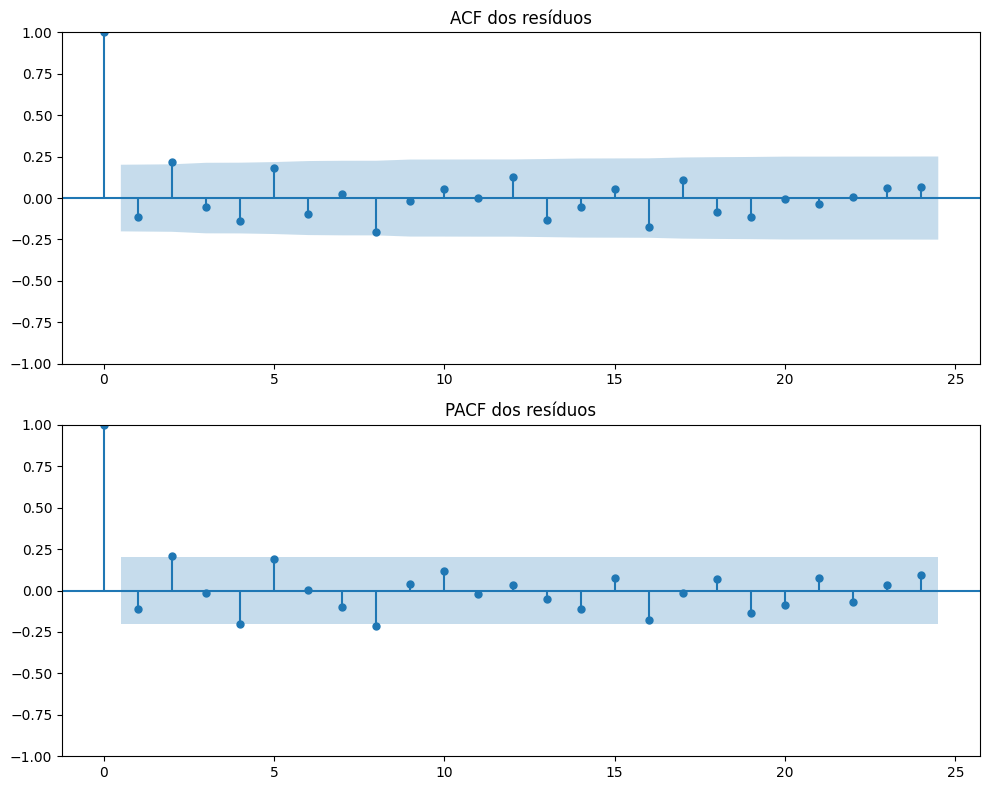

Teste de Ljung-Box (lag 12):
       lb_stat  lb_pvalue
12  19.209601   0.083594

--- Região: centro_oeste ---
                  Generalized Linear Model Regression Results                   
Dep. Variable:     mental_health_visits   No. Observations:                   95
Model:                              GLM   Df Residuals:                       89
Model Family:          NegativeBinomial   Df Model:                            5
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -1069.5
Date:                  qui, 01 mai 2025   Deviance:                       1.4605
Time:                          14:43:12   Pearson chi2:                     1.47
No. Iterations:                       6   Pseudo R-squ. (CS):            0.06832
Covariance Type:                    HAC                                         
                        coef    std err          z      P>|z|      [0.025      0

c:\Users\Lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


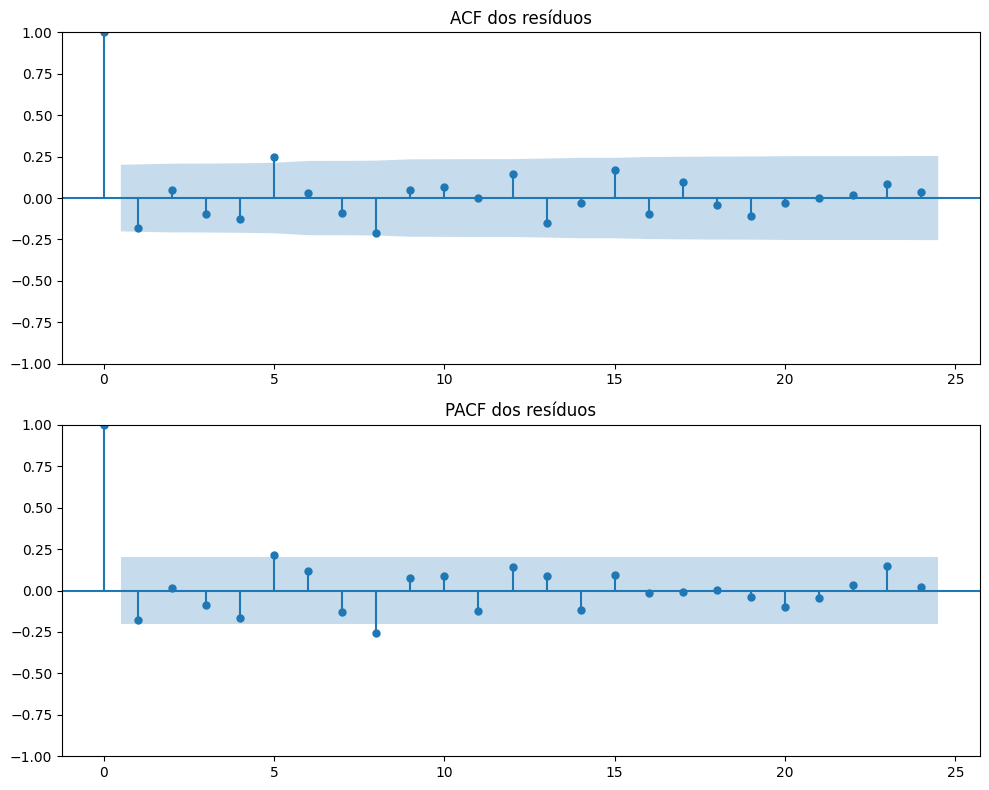

Teste de Ljung-Box (lag 12):
       lb_stat  lb_pvalue
12  21.174055   0.047889

--- Região: nordeste ---
                  Generalized Linear Model Regression Results                   
Dep. Variable:     mental_health_visits   No. Observations:                   95
Model:                              GLM   Df Residuals:                       89
Model Family:          NegativeBinomial   Df Model:                            5
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -1154.8
Date:                  qui, 01 mai 2025   Deviance:                       2.0707
Time:                          14:43:13   Pearson chi2:                     2.09
No. Iterations:                       7   Pseudo R-squ. (CS):             0.1973
Covariance Type:                    HAC                                         
                        coef    std err          z      P>|z|      [0.025      0.975

c:\Users\Lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


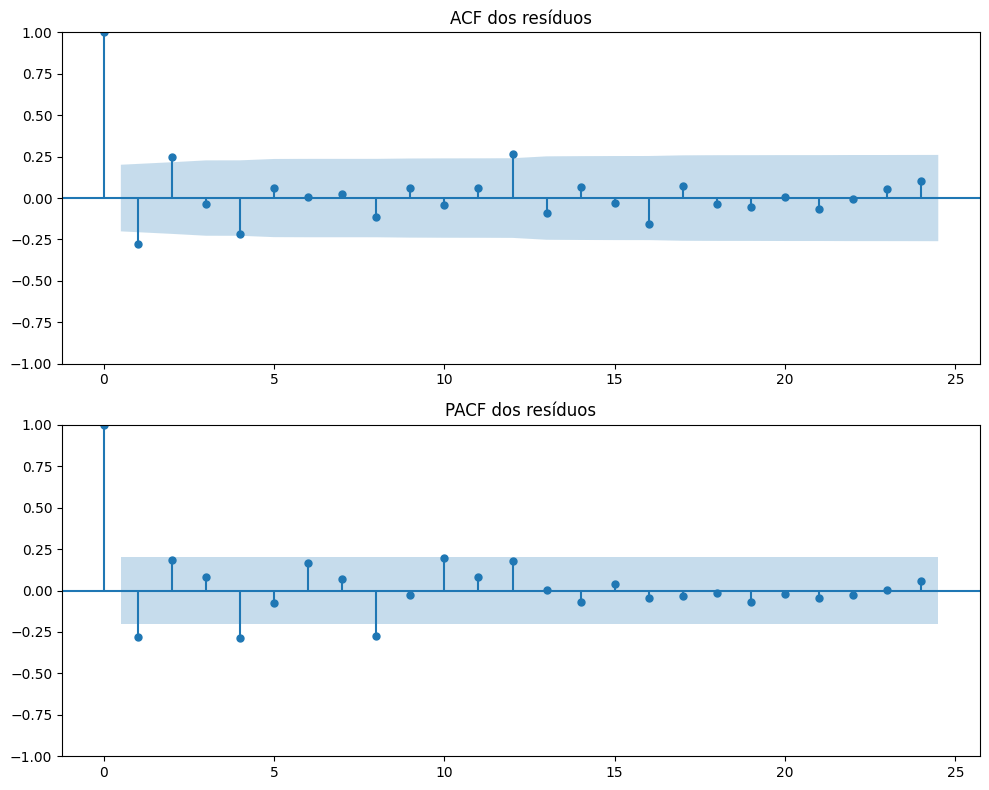

Teste de Ljung-Box (lag 12):
       lb_stat  lb_pvalue
12  29.130647   0.003768

--- Região: norte ---
                  Generalized Linear Model Regression Results                   
Dep. Variable:     mental_health_visits   No. Observations:                   95
Model:                              GLM   Df Residuals:                       89
Model Family:          NegativeBinomial   Df Model:                            5
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -1002.2
Date:                  qui, 01 mai 2025   Deviance:                       1.4489
Time:                          14:43:13   Pearson chi2:                     1.46
No. Iterations:                       6   Pseudo R-squ. (CS):             0.1167
Covariance Type:                    HAC                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-

c:\Users\Lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


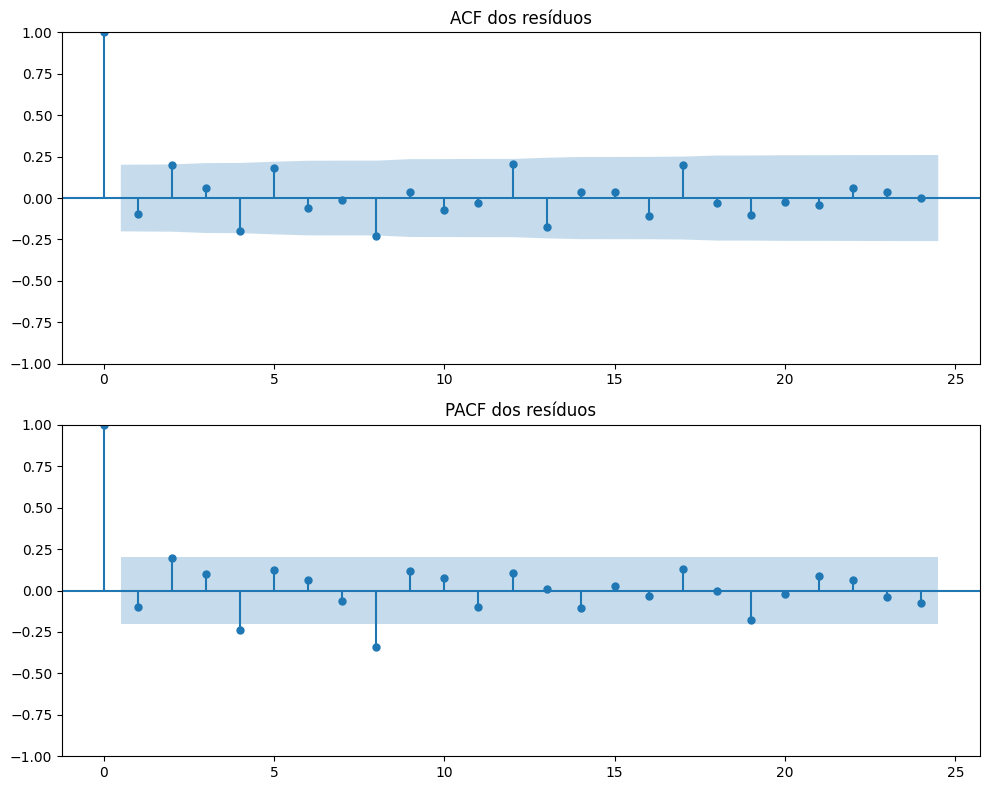

Teste de Ljung-Box (lag 12):
      lb_stat  lb_pvalue
12  24.00766   0.020292

--- Região: sudeste ---
                  Generalized Linear Model Regression Results                   
Dep. Variable:     mental_health_visits   No. Observations:                   95
Model:                              GLM   Df Residuals:                       89
Model Family:          NegativeBinomial   Df Model:                            5
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -1235.6
Date:                  qui, 01 mai 2025   Deviance:                       1.0876
Time:                          14:43:13   Pearson chi2:                     1.08
No. Iterations:                       6   Pseudo R-squ. (CS):            0.07772
Covariance Type:                    HAC                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-

c:\Users\Lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


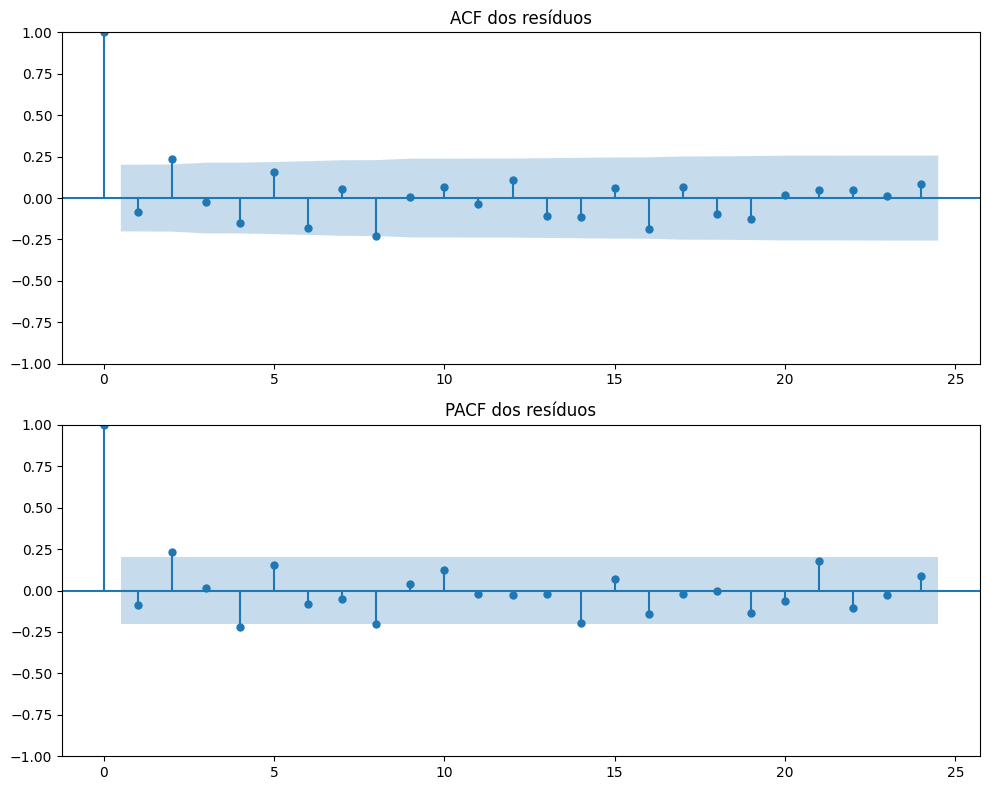

Teste de Ljung-Box (lag 12):
       lb_stat  lb_pvalue
12  22.349759   0.033782

--- Região: sul ---
                  Generalized Linear Model Regression Results                   
Dep. Variable:     mental_health_visits   No. Observations:                   95
Model:                              GLM   Df Residuals:                       89
Model Family:          NegativeBinomial   Df Model:                            5
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -1192.2
Date:                  qui, 01 mai 2025   Deviance:                      0.30624
Time:                          14:43:14   Pearson chi2:                    0.301
No. Iterations:                       4   Pseudo R-squ. (CS):           0.005643
Covariance Type:                    HAC                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
---

c:\Users\Lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


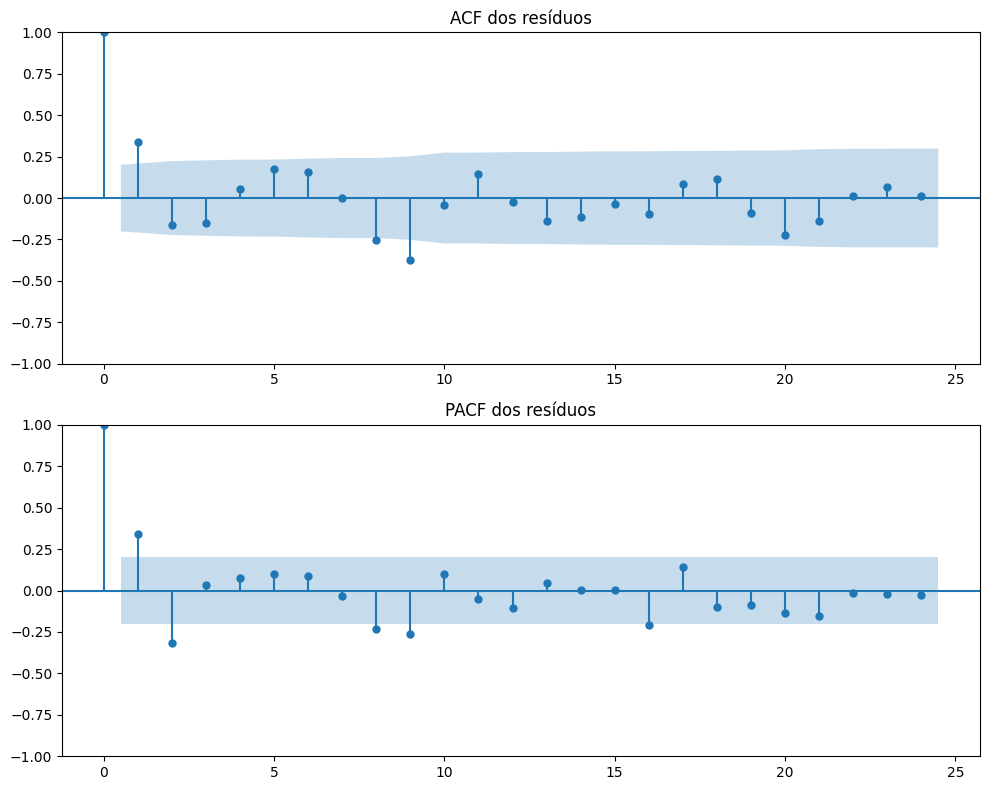

Teste de Ljung-Box (lag 12):
       lb_stat  lb_pvalue
12  46.788792   0.000005

--- Brasil (todas as regiões) ---
                  Generalized Linear Model Regression Results                   
Dep. Variable:     mental_health_visits   No. Observations:                  575
Model:                              GLM   Df Residuals:                      569
Model Family:          NegativeBinomial   Df Model:                            5
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -7054.9
Date:                  qui, 01 mai 2025   Deviance:                       66.372
Time:                          14:43:14   Pearson chi2:                     60.4
No. Iterations:                       8   Pseudo R-squ. (CS):            0.05859
Covariance Type:                    HAC                                         
                        coef    std err          z      P>|z|      [0.025  

c:\Users\Lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


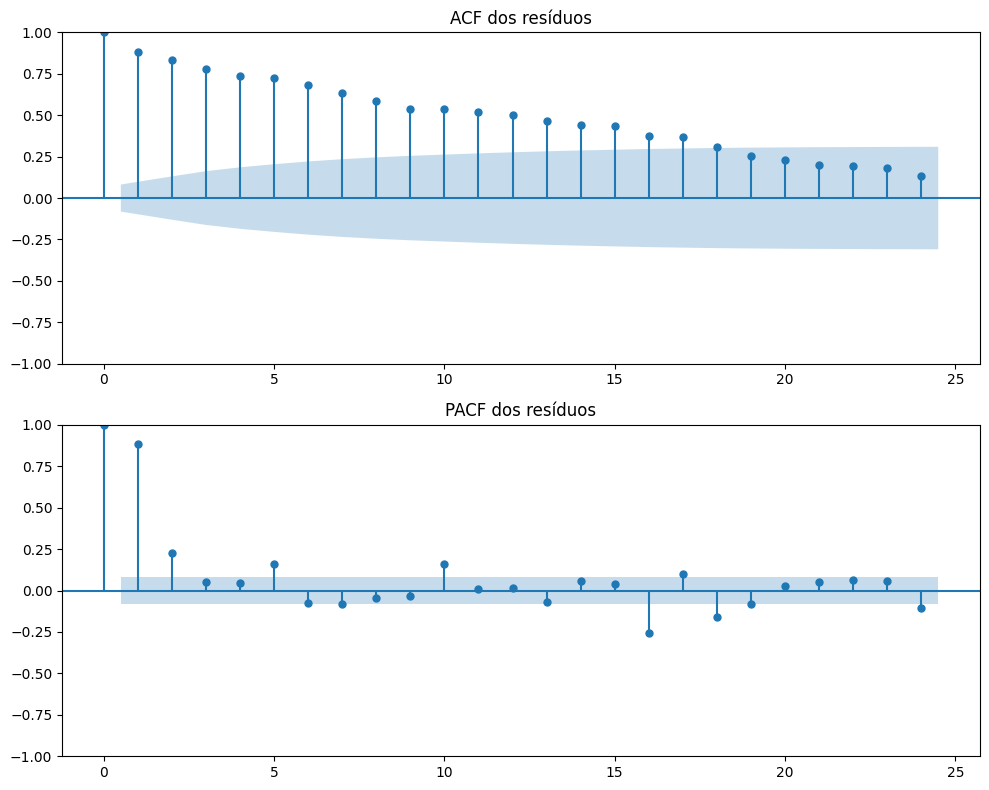

Teste de Ljung-Box (lag 12):
        lb_stat  lb_pvalue
12  3180.08841        0.0


In [34]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def adicionar_dummies_intervencao(
    df, 
    col_data='date',
    pandemia_ini='2020-04-01', pandemia_fim='2022-03-01',
    pospandemia_ini='2022-04-01', pospandemia_fim='2023-12-01'
):
    """
    Adiciona Pandemia_Step, Pandemia_Trend, PosPandemia_Step e PosPandemia_Trend.
    """
    df = df.copy()
    df[col_data] = pd.to_datetime(df[col_data])
    # converter strings para Timestamp
    pini, pfim = pd.to_datetime(pandemia_ini), pd.to_datetime(pandemia_fim)
    rini, rfim = pd.to_datetime(pospandemia_ini), pd.to_datetime(pospandemia_fim)

    # step bins
    df['Pandemia_Step'] = ((df[col_data] >= pini) & (df[col_data] <= pfim)).astype(int)
    df['PosPandemia_Step'] = ((df[col_data] >= rini) & (df[col_data] <= rfim)).astype(int)

    # trend counters
    df['Pandemia_Trend'] = 0
    df.loc[df['Pandemia_Step']==1, 'Pandemia_Trend'] = np.arange(1, df['Pandemia_Step'].sum()+1)
    df['PosPandemia_Trend'] = 0
    df.loc[df['PosPandemia_Step']==1, 'PosPandemia_Trend'] = np.arange(1, df['PosPandemia_Step'].sum()+1)

    return df

def preparar_glm_nb_hac(
    df, 
    col_dep='mental_health_visits', 
    col_offset='total_atd', 
    col_data='date',
    maxlag=12
):
    """
    Prepara dados, ajusta GLM NegBin com término autorregressivo e erros HAC.
    Retorna o objeto results.
    """
    # cria dummies
    df2 = adicionar_dummies_intervencao(df, col_data=col_data)
    # lag 1 da variável dependente
    df2['y_lag1'] = df2[col_dep].shift(1)
    df2 = df2.dropna(subset=[col_dep, col_offset, 'y_lag1'])

    # endógena e exógenas
    endog = df2[col_dep]
    exog = df2[['Pandemia_Step','Pandemia_Trend','PosPandemia_Step','PosPandemia_Trend','y_lag1']]
    exog = sm.add_constant(exog)

    # offset por total_atd / 1000
    offset = np.log(df2[col_offset] / 1000)

    model = sm.GLM(
        endog, 
        exog, 
        family=sm.families.NegativeBinomial(), 
        offset=offset
    )
    results = model.fit(
        cov_type='HAC', 
        cov_kwds={'maxlags': maxlag}
    )
    return results, df2

def diagnostico_residuos(results, df2):
    """
    Plota ACF/PACF dos resíduos e testa Ljung–Box para lag=12.
    """
    resid = results.resid_response

    # ACF e PACF
    fig, axes = plt.subplots(2,1, figsize=(10,8))
    plot_acf(resid, ax=axes[0], lags=24)
    axes[0].set_title('ACF dos resíduos')
    plot_pacf(resid, ax=axes[1], lags=24)
    axes[1].set_title('PACF dos resíduos')
    plt.tight_layout()
    plt.show()

    # Ljung-Box
    lb = acorr_ljungbox(resid, lags=[12], return_df=True)
    print("Teste de Ljung-Box (lag 12):\n", lb)

# Exemplo de uso:
if __name__ == "__main__":
    # carregar seu DataFrame
    #RegressionDF = pd.read_csv("seu_arquivo.csv")  # ou pd.read_parquet, etc.

    # rodar por macrorregião
    resultados = {}
    for regiao, df_reg in RegressionDF.groupby('regiao'):
        res, df_preparado = preparar_glm_nb_hac(df_reg)
        print(f"\n--- Região: {regiao} ---")
        print(res.summary())
        diagnostico_residuos(res, df_preparado)
        resultados[regiao] = res

    # rodar para o Brasil inteiro
    res_br, df_br = preparar_glm_nb_hac(RegressionDF)
    print("\n--- Brasil (todas as regiões) ---")
    print(res_br.summary())
    diagnostico_residuos(res_br, df_br)
